<a href="https://colab.research.google.com/github/wwerkk/audio-segment/blob/main/GrainModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#@title README
!yes | pip install --quiet pyfiglet

import pyfiglet
  
resulta = pyfiglet.figlet_format(f"Language Modelled Concatenative Synthesis", font = "larry3d", width = 150)
resultb = pyfiglet.figlet_format(f"v0.2", font = "larry3d")
print(resulta)
print(resultb)
print("\n")
print("\n")
print("Language Modelled Concatenative Synthesis | Author: W. K. Werkowicz | https://github.com/wwerkk | https://wwerk.notion.site")
print("Development blog | https://wwerkk.github.io")
print("\n")
print("Last Modified: 11.03.2023")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 11.8 MB/s eta 0:00:00
 __                                                                                         __          ___    ___              __     
/\ \                                                                    /'\_/`\            /\ \        /\_ \  /\_ \            /\ \    
\ \ \         __      ___      __   __  __     __       __      __     /\      \    ___    \_\ \     __\//\ \ \//\ \      __   \_\ \   
 \ \ \  __  /'__`\  /' _ `\  /'_ `\/\ \/\ \  /'__`\   /'_ `\  /'__`\   \ \ \__\ \  / __`\  /'_` \  /'__`\\ \ \  \ \ \   /'__`\ /'_` \  
  \ \ \L\ \/\ \L\.\_/\ \/\ \/\ \L\ \ \ \_\ \/\ \L\.\_/\ \L\ \/\  __/    \ \ \_/\ \/\ \L\ \/\ \L\ \/\  __/ \_\ \_ \_\ \_/\  __//\ \L\ \ 
   \ \____/\ \__/.\_\ \_\ \_\ \____ \ \____/\ \__/.\_\ \____ \ \____\    \ \_\\ \_\ \____/\ \___,_\ \____\/\____\/\____\ \____\ \___,_\
    \/___/  \/__/\/_/\/_/\/_/\/___L\ \/___/  \/__/\/_/\/___L\ \/____/     \/_/ \/_/\/___/  \/__,_ /\/__

## 1. Setup

In [5]:
#@title Optional: Mount Google Drive
use_google = True #@param {type:"boolean"}
if use_google:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title Install and import dependencies
!pip install --quiet mir_eval audio2numpy git+https://github.com/caillonantoine/UDLS.git@v1.0.0#egg=udls
!pip install --quiet numpyencoder
import math
import random, numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa
import librosa.display
import mir_eval
import IPython.display
import urllib
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import RMSprop
import tensorflow as tf
from audio2numpy import open_audio
import os
import sys
import soundfile as sf
import shelve
from pathlib import Path
import json
from numpyencoder import NumpyEncoder

  Preparing metadata (setup.py) ... done


In [6]:
#@title Load existing model

#@markdown **TODO: some sort of warning if any of the files are not found**
#@markdown ---
load_existing = True #@param {type:"boolean"}
 
if load_existing:
  name = "pulsex" #@param {type:"string"}
  path = "/content/drive/MyDrive/GrainModelling/pulsex" #@param {type:"string"}

  config_path = path + f"/{name}_config.json"
  dict_path = path + f"/{name}_frames.json"
  features_path = path + f"/{name}_features.json"
  model_path = path + f"/{name}.keras"

  config = json.load(open(config_path))
  fs = config['fs']
  n_clusters = config['n_clusters']
  onset_detection = config['onset_detection']
  labelled_frames = json.load(open(dict_path)) # for some reason this doesn't load as it should
  encoded_features = json.load(open(features_path))
  model = keras.models.load_model(model_path)
#@markdown **Warning: After loading the dictionary and model you should skip to Generation**

## 2. Model training

In [ ]:
#@title Optional: Download audio from YouTube
youtube_dl = False #@param {type:"boolean"}
if youtube_dl:
  youtube_url = "" #@param {type:"string"}
  dl_path = "" #@param {type:"string"}
  !mkdir audio
  !cd audio
  !pip install yt-dlp --quiet
  !yt-dlp -x "{youtube_url}" -o "{dl_path}/extracted_audio"

In [ ]:
#@title Load and preprocess audio
directory = "/content/drive/MyDrive/GrainModelling/audioData" #@param {type:"string"}
sample_len = 240 #@param {type:"integer"} length (s) of each sample to be taken from the dataset
fs = 24000 #@param {type:"integer"} sampling rate
augment = True #@param {type:"boolean"}
#@markdown ---

### resample audio into given 
# using UDLS utility by antoine caillon
if augment:
  !resample --input {directory} --output "{directory}/preprocessed" --len {sample_len} --sr {fs} --augment
else:
  !resample --input {directory} --output "{directory}/preprocessed" --len {sample_len} --sr {fs}

### load data
audio_data = []
preprocessed_dir = directory + "/preprocessed/" + "out_" + str(fs)
for i, file in enumerate(os.listdir(preprocessed_dir)):
    x, fs = open_audio(preprocessed_dir + "/" + file)
    audio_data.append(x)
audio_data = np.array(audio_data, dtype=object)
print(audio_data.shape)

Traceback (most recent call last):
  File "/usr/local/bin/resample", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.9/dist-packages/udls/resample.py", line 29, in main
    makedirs(out_dir)
  File "/usr/lib/python3.9/os.py", line 225, in makedirs
    mkdir(name, mode)
FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/GrainModelling/audioData/preprocessed/out_24000'
(4,)


In [112]:
#@title Segment
#@markdown **TODO: onset_detection = False fix**
onset_detection = True #@param {type:"boolean"}
#@markdown onset settings:
backtrack = True #@param {type:"boolean"}
onset_delta = 0.198 #@param {type:"slider", min:0, max:0.5, step:0.001}
#@markdown if onset_detection is off, slice length is specified manually in seconds:
slice_length = 2 #@param {type:"integer"}
#@markdown ---
plot = False #@param {type:"boolean"}

def slice_onsets(y, sr, delta):
    slice_frames = librosa.onset.onset_detect(y=y, sr=sr, wait=0.2, backtrack=backtrack, delta=onset_delta)
    slice_samples = librosa.frames_to_samples(slice_frames)
    return slice_samples
def slice_even(y, sr, slice_length):
    hop_length = math.ceil(slice_length * fs)
    slice_samples = [* np.arange(0, len(y), slice_length)]
    return slice_samples
# segment audio into grains
if onset_detection:
    slice_samples = [slice_onsets(sample, fs, onset_delta) for sample in audio_data]
else: 
    slice_samples = [slice_even(sample, fs, slice_length) for sample in audio_data]
slice_samples = np.array(slice_samples, dtype=object)
print(slice_samples.shape)
# print(len(slice_samples[0]) + len(slice_samples[1]) + len(slice_samples[2])) # sanity check
frames = []
for s, a in zip(slice_samples, audio_data):
    # print(frame)
    # print(s, a)
    for start, end in zip(s[:-1], s[1:]):
        frames.append(a[start:end])
        # print(a[start:end])
        # print(start, end)
    try:
        frames.append(a[s[-1]:]) # append last frame
    except IndexError:
        pass
frames = np.array(frames, dtype=object)
print(frames.shape)

if plot:
  for i in range(1, frames.shape[0], int(frames.shape[0] / 3)):
      librosa.display.waveshow(frames[i], sr=fs) # display the waveform
      display(IPython.display.Audio(frames[i], rate=fs)) # play audio file using ipython display
      plt.show()

(4,)
(1959,)


In [115]:
#@title Cluster
clustering = "kmeans"   #@param ["kmeans", "dbscan", "af"]
#@markdown if kmeans:
n_clusters = 8 #@param {type: "integer"} only applies to kmeans
#@markdown if af:
eps = 0.5 #@param {type: "number"} in case of affinity propagation
min_samples = 3 #@param {type: "integer"} in case of affinity propagation
#@markdown ---
plot = False #@param {type:"boolean"}
# Remove empty grains
frames = [frame for frame in frames if frame.size != 0]

# Extract features
def extract_features(x, fs):
    features = np.array([])
    zcr = librosa.zero_crossings(x).sum() # zero crossing rate - this corresponds to pitch
    energy = scipy.linalg.norm(x) # summed energy of each frame
    features = np.array([zcr, energy])
    if len(x) >= 2048:  
        mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13, ) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13, n_fft=len(x), hop_length=len(x))
    m_mfcc = np.median(mfccs[1:], axis=1) # first mfcc corresponds to energy which we already got, so we can ignore it
    features = np.append(features, m_mfcc) # stack everything together
    return features

features = np.array([extract_features(frame, fs) for frame in frames])
print(features.shape)
print(features[0])
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))
print(features_scaled[0])
if plot:
  plt.scatter(features_scaled[:,0], features_scaled[:,1])
  plt.xlabel('Zero Crossing Rate (scaled)')
  plt.ylabel('Spectral Centroid (scaled)')    

# Classify
if clustering == "kmeans":
    c_model = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init='auto')
    labels = c_model.fit_predict(features_scaled)
elif clustering == "dbscan":
    c_model = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    labels = c_model.fit_predict(features_scaled)
    labels += 1 # dbscan returns -1 for outliers, so we add 1 to all labels
else:
    c_model = sklearn.cluster.AffinityPropagation(damping=0.5, max_iter=900)
    labels = c_model.fit_predict(features_scaled)
n_labels = len(np.unique(labels))
print("n_labels:", n_labels)
len(labels)

labelled_frames = dict()
# Store the labelled frame in a dictionary
for i, label in enumerate(labels):
    if label not in labelled_frames:
        labelled_frames[str(label)] = []
    labelled_frames[str(label)].append(frames[i])
# print(len(labelled_frames[0])) # sanity check

# preview cluster plots
if plot:
  for i in range(0, 5):
      print("------------------")
      print("Label: ", i)
      f = get_frame(labelled_frames, i)
      D = librosa.amplitude_to_db(np.abs(librosa.stft(f, hop_length=1024)),
                              ref=np.max)
      librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=1024,
                          x_axis='time')
      plt.show()
      librosa.display.waveshow(f, sr=fs) # display the waveform
      plt.show()
      display(IPython.display.Audio(f, rate=fs)) # play audio file using ipython display
      plt.show()



(1959, 14)
[182.          20.02301788 228.44393921   4.57059765   6.53045177
  25.42328644  13.25311852  10.39282417   8.56349945   6.89078331
   4.44105244   1.77247679   3.43031263   3.05404282]
(1959, 14)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.95502203 -0.45948229  0.86897764  0.05416008  0.14232261  0.3998512
 -0.37963876 -0.25823716 -0.36789793 -0.00351724 -0.55125958 -0.31404245
 -0.44415552 -0.33796455]
n_labels: 8


In [116]:
#@title Train model

######## TODO: Implement K-Fold validation

epochs = 2 #@param {type: "integer"} training epochs
batch_size = 32 #@param {type: "integer"} training batch size
maxlen = n_clusters # length of the input sequence window
step = 2 #@param {type: "integer"} step size for the sliding window
hidden_units = 24 #@param {type: "integer"} number of hidden units in the GRU layer
callback = False #@param {type: "boolean"}
#@markdown ---
#@markdown **TODO:**\
#@markdown K-Fold validation settings:
k_fold_on = False #@param {type: "boolean"}
k = 2 #@param {type:"integer"}

# One-hot encode
# build a subsequence for every <step> frames
# and a corresponding label that follows it
features = [] # these will be features
targets = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    features.append(labels[i: i + maxlen])
    targets.append(labels[i + maxlen])
# one-hot encode features and targets
# adapted from wandb character generation code referenced at the beginning of this notebook
encoded_features = np.zeros((len(features), maxlen, n_labels), dtype=bool)
encoded_targets = np.zeros((len(targets), n_labels), dtype=bool)
for i, sequence in enumerate(features):
    # print(i, sequence)
    for t, label in enumerate(sequence):
        encoded_features[i, t, label] = 1
        # print(encoded_features[i, t])
    encoded_targets[i, targets[i]] = 1
# sanity check
print(encoded_features.shape)
print(encoded_targets.shape)

# Build and compile model

## optional - if training on GPU
# keras.mixed_precision.set_global_policy("mixed_float16")

# adapted from wandb character generation code referenced at the beginning of this notebook
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units, return_sequences=True)(inputs)
# according to DLWP [13.2.1] softmax tends to be unstable in float16
outputs = Dense(n_labels, activation='softmax', dtype="float32")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy', # since we are using integer labels
    optimizer="rmsprop",
    metrics=['accuracy']
    )
model.summary()

# Callback
class SampleGrain(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        seed = np.array([random.choice(encoded_features)])
        seq = seed
        print("\nGenerating with seed:\n", seed.astype(int))
        for temperature in [0.5, 1.2]:
            print("Temperature:\n", temperature)
            for i in range(sequence_length):
                preds = model.predict(seq, verbose=0)
                # print(preds)
                p_label = sample(preds[0], temperature)
                encoded_pred = np.eye(n_labels)[p_label].astype(bool)
                encoded_pred = np.array([[encoded_pred]])
                # print("\nPrediction: ", encoded_pred.astype(int))
                # print("\nPrediction: ", np.argmax(encoded_pred))
                # print(seed.shape, encoded_pred.shape)
                # seq = np.delete(seq, 0, axis=1)
                seq = np.concatenate((seq, encoded_pred), axis=1)
                # print("Predicted sequence:\n", seq.astype(int))
                # print("\n", seq.shape)
# Train
if callback:
  #@title Train
  model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=[SampleGrain()]
  )
else:
  model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,

  )

(976, 8, 8)
(976, 8)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8)]            0         
                                                                 
 gru (GRU)                   (None, 8, 24)             2448      
                                                                 
 dense (Dense)               (None, 8, 8)              200       
                                                                 
Total params: 2,648
Trainable params: 2,648
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
31/31 [==============================] - 2s 6ms/step - loss: 1.8300 - accuracy: 0.6644
Epoch 2/2
31/31 [==============================] - 0s 5ms/step - loss: 1.1154 - accuracy: 0.8750


In [17]:
#@title (Optional) Save the audio frames and model
#@markdown **TODO: Use start and and sample indices instead of entire frames**
save_model = True #@param {type: "boolean"}
save_dict = True #@param {type: "boolean"}
save_features = True #@param {type: "boolean"}
save_config = True #@param {type: "boolean"}
name = "pulsex" #@param {type:"string"}
directory = "/content/drive/MyDrive/GrainModelling/" #@param {type:"string"}
path = Path(directory + "/" + name)
path.mkdir(exist_ok=True)
model_path = path / (name + ".keras")
if save_model:
  model.save(model_path)
if save_dict:
  dict_path = path / (name + "_frames.json")
  dict_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
if save_features:
  f_path = path / (name + "_features.json")
  f_path.write_text(json.dumps(encoded_features, cls=NumpyEncoder))
if save_config:
  params = dict()
  params["fs"] = fs
  params["n_clusters"] = n_clusters
  params["onset_detection"] = onset_detection
  p_path = path / (name + "_config.json")    
  p_path.write_text(json.dumps(params))

## 3. Generation

In [31]:
#@title Generate sequence
sequence_length = 256 #@param {type: "integer"} no. tokens in generated sequence
temperature = 1.85 #@param {type:"slider", min:0, max:20, step:0.01}
#@markdown set to -1 for random:
seed = -1 #@param {type: "raw"}

# Sampling function
# adapted from wandb character generation code referenced at the beginning of this notebook
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generate output
def generate(model, sequence_length, temperature=1.0, seed=-1):
    if seed == -1:
      seq = np.array([random.choice(list(encoded_features))])
    else:
      seq = np.array([(encoded_features[seed])])
    print("\nGenerating with seed:", "random" if (seed == -1) else seed, "\n", np.argmax(seq, axis=1))
    print("Temperature:\n", temperature)
    for i in range(sequence_length):
        preds = model.predict(seq, verbose=0)
        # print(preds)
        p_label = sample(preds[0], temperature)
        encoded_pred = np.eye(n_clusters)[p_label].astype(bool)
        encoded_pred = np.array([[encoded_pred]])
        # print("\nPrediction: ", encoded_pred.astype(int))
        # print("\nPrediction: ", np.argmax(encoded_pred))
        # print(seed.shape, encoded_pred.shape)
        seq = np.concatenate((seq, encoded_pred), axis=1) # add the prediction to the sequence
        # print(seq.astype(int))
        # print("Predicted sequence:\n", seq.astype(int))
        # print("\n", seq.shape)
        # print("Predicted sequence:\n", seq.astype(int))
    return seq

# Retrieve frame from dictionary
def get_frame(d, label):
    return random.choice(d[label])

if seed == -1:
  seq = generate(model, sequence_length=sequence_length, temperature=temperature)
else: 
  seq = generate(model, sequence_length=sequence_length, seed=seed, temperature=temperature)
g_ints = np.argmax(seq[0], axis=1)
print("Generated sequence:")
print(g_ints)
g_ints = [str(i) for i in g_ints]
g_frames = [np.array(get_frame(labelled_frames, label)) for label in g_ints]
# g_frames.shape[0] / fs


Generating with seed: random 
 [[0 0 3 0 1 2 4 0]]
Temperature:
 1.85
Generated sequence:
[3 4 5 2 6 3 4 2 6 6 0 6 1 2 3 2 0 1 7 1 0 0 3 2 4 0 0 1 2 2 7 7 3 3 7 7 0
 0 1 0 2 3 4 2 4 4 5 6 7 0 5 0 0 0 6 7 2 3 7 7 6 0 1 5 2 7 4 1 3 5 3 0 4 4
 1 7 0 0 0 6 3 4 2 4 0 4 3 0 5 1 0 7 7 0 7 0 4 0 2 5 5 4 0 2 3 2 4 2 0 6 3
 7 1 2 5 0 7 5 4 2 4 2 0 2 6 0 0 0 4 1 1 5 0 3 1 5 7 4 0 4 3 3 6 0 5 5 3 0
 3 7 4 2 2 4 1 2 4 6 1 2 5 2 3 0 7 4 2 2 3 0 2 3 7 0 3 0 3 3 4 5 5 1 6 6 7
 5 4 7 0 6 1 4 4 7 7 2 6 3 1 2 7 1 3 4 3 5 6 0 0 4 0 1 5 0 2 6 7 3 4 4 4 5
 6 6 7 2 6 1 2 2 2 6 1 6 0 5 0 1 7 0 7 0 6 1 0 4 7 1 6 5 7 0 4 1 7 6 5 2 6
 6 7 0 2 4]


264
196 (247720,) (267187,)
OINK
[-0.23223877 -0.27728271 -0.36264038 ...  0.          0.
  0.        ]
206 (231887,) (267187,)
OINK
[-3.29895020e-02  1.35192871e-02  4.76379395e-02 ...  4.47034836e-10
  1.25832028e-10  1.26935818e-11]
215 (235417,) (267187,)
OINK
[-4.22393799e-01 -4.61242676e-01 -4.92279053e-01 ...  4.47034836e-10
  1.25832028e-10  1.26935818e-11]
222 (242477,) (267187,)
OINK
[-2.38708496e-01 -2.55981445e-01 -2.81250000e-01 ...  4.47034836e-10
  1.25832028e-10  1.26935818e-11]
223 (263657,) (267187,)
OINK
[6.12487793e-02 5.36499023e-02 2.81372070e-02 ... 4.47034836e-10
 1.25832028e-10 1.26935818e-11]
226 (256597,) (267187,)
OINK
[-1.17584229e+00 -1.14630127e+00 -1.10281372e+00 ...  4.47034836e-10
  1.25832028e-10  1.26935818e-11]
231 (249537,) (267187,)
OINK
[-9.55993652e-01 -9.92034912e-01 -1.02410889e+00 ...  4.47034836e-10
  1.25832028e-10  1.26935818e-11]
233 (260127,) (267187,)
OINK
[5.25207520e-02 1.23199463e-01 1.85119629e-01 ... 4.47034836e-10
 1.25832028e-10 

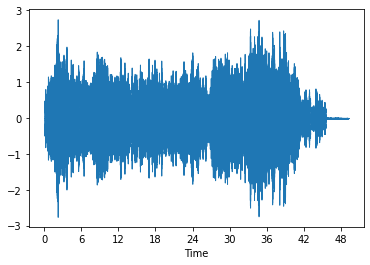

In [34]:
#@title Resynthesise
fade_length = 0.02 #@param {type: "number"}
emitter = True #@param {type: "boolean"}
#@markdown for emitter mode:
BPM = 136 #@param {type: "number"} BPM
beat_density = 1/12 #@param {type: "number"} grain emission rate in fractions of a beat
#@markdown for overlap mode:
overlap = 0.01 #@param {type: "number"} grain overlap (s) for resynthesis

density = (4 * beat_density * 60 / BPM)

def apply_fade(frame, length):
    """Apply a fade-in and fade-out to the given frame.
    frame: input frame
    length: length of fade in seconds
    """
    length = math.ceil(length * fs)
    fadein = np.arange(0, 1, 1/length)
    fadeout = 1 - fadein
    frame[:length] *= fadein
    frame[-length:] *= fadeout
    return frame

if onset_detection:
    # Apply a linear fade-in and out to each frame
    g_frames = np.array([apply_fade(frame, fade_length) for frame in g_frames], dtype=object)
else:
    # Apply a Hann window to each frame
    g_frames = np.array([frame * scipy.signal.hann(len(frame)) for frame in g_frames], dtype=object)

# Concatenate audio
def dense_concatenate(grains, fs, density):
    """ Concatenate grains with given density.
    grains: list of grains to resynthesise from
    density: density of grain emission in seconds
    """
    # Remove empty grains
    max_len = np.max([(grain.shape[0]) for grain in grains])
    padded_sequence = [np.pad(grain[0], (0, max_len - grain.shape[0]), mode='constant') for grain in grains]
    print(len(padded_sequence))
    density = math.ceil(density * fs) # convert to samples
    total_len = len(grains) * density + len(grains[-1]) # total length of the output signal
    y = np.zeros(total_len) # initialize output signal
    for i, grain in enumerate(grains):
        if i == 0:
            start = 0
        else:
            start = start + density
        end = start + len(grain)
        if y[start:end].shape != grain.shape: # for debugging
            print(i, y[start:end].shape, grain.shape)
            print("OINK")
            print(y[start:end])
            y = np.pad(y, (0, grain.shape[0] - y[start:end].shape[0]), mode='constant')
        y[start:end] += np.array(grain) # add grain to output signal
        # print(i, start, end, len(grain))
    return y # return the output signal

def overlap_concatenate(grains, fs, overlap):
    """ Concatenate grains with given overlap.
    grains: list of grains to resynthesise from
    overlap: overlap between grains in seconds
    """
    # Remove empty grains
    # Calculate number of samples for the overlap
    overlap_samples = int(overlap * fs)
    # Initialize the output array
    output = grains[0]
    # Iterate through the grains, starting from the second one
    for i in range(1, len(grains)):
        # Get the current grain and the previous one
        current_grain = grains[i]
        previous_grain = output[-overlap_samples:]
        # Check if current grain is shorter than the overlap
        if current_grain.shape[0] < overlap_samples:
            overlapped_samples = previous_grain[:current_grain.shape[0]] + current_grain
            output = np.concatenate((output[:-current_grain.shape[0]], overlapped_samples))
        else:
            # Sum the overlapped samples
            overlapped_samples = previous_grain + current_grain[:overlap_samples]
            # Concatenate the overlapped samples with the current grain
            output = np.concatenate((output[:-overlap_samples], overlapped_samples, current_grain[overlap_samples:]))
    return output

if emitter:
  out = dense_concatenate(g_frames, density, fs) # concatenate the grains
else:
  out = overlap_concatenate(g_frames, overlap, fs) # concatenate the grains
librosa.display.waveshow(out, sr=fs) # display the waveform
play = IPython.display.Audio(out, rate=fs) # play audio file using ipython display
IPython.display.display(play)

In [ ]:
#@title Save audio
filename = "pulse-x-out" #@param {type: "string"}
filename += f"-generation-{sequence_length}-tokens-{density}-density.wav"
output_path = "/content/drive/MyDrive/GrainModelling/pulsex" #@param {type:"string"}
output_path += ("/" + filename)
print("Saving", output_path)
sf.write(output_path, out, fs) # write audio file to disk